<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/%E1%84%80%E1%85%B5%E1%84%89%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5(%E1%84%91%E1%85%A9%E1%86%A8%E1%84%8B%E1%85%A7%E1%86%B7)_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D(project2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Me

---

- 개 더운 여름(2021-07-27)에 폭염 때문에 빡친 나는 역대 폭염에 대해 흥미를 가졌고 데이터 분석을 결심한다.

 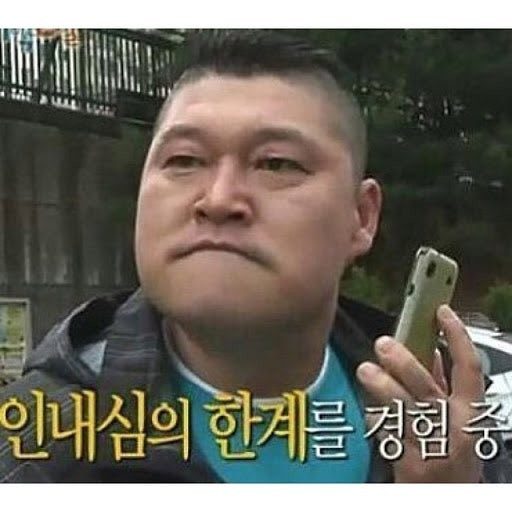

- 데이터 셋은 기상청기상자료개방포털(https://data.kma.go.kr/cmmn/main.do)에서 가져 왔다.

- 데이터는 [일시, 지점, 폭염여부(O/X), 최고체감온도(°C), 최고기온(°C), 평균기온(°C), 최저기온(°C), 평균상대습도(%), 폭염특보(O/X), 폭염영향예보(단계), 열대야(O/X), 자외선지수(단계)]의 테이블로 구성되어 있다.

- 데이터의 기간[일시]는 **2019-05 ~ 2021-07**까지 수집 되었다.

- 데이터는 도시별 1일 간격으로 수집되었다.

- 각 컬럼에 NaN값도 존재한다. ==> 그 지역, 그 시기 값의 평균or중위수로 치환

- 데이터[폭염영향예보(단계)] = ' ', '관심', '주의', '경고', '심각'으로 구성
 - ' '는 폭염과 관련 없는 날씨를 의미 하기 때문에 '평시'로 replace

In [183]:
!apt-get update -qq  ## 나눔 설치
!apt-get install fonts-nanum* -qq

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

In [185]:
import matplotlib as mpl
import matplotlib.font_manager as fm   ## 폰트 매니저
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font) 
mpl.font_manager._rebuild()

# Contents



1. 데이터 불러오기



2. 시각화(Visualization)
 - 시계열별 기온(°C) EDA
 - 도시별 기온(°C) EDA
 - 체감기온(°C)의 상관계수

3. 누락 값 처리(NaN 처리)

4. Modeling
 - 모델별로


---
# 1. 데이터 불러오기

 - 기상자료개방포털에서 데이터들을 모아 excel작업을 했다.


In [186]:
data = pd.read_excel('/content/drive/MyDrive/dataset/공공데이터/폭염데이터-기상청/기상데이터(폭염).xlsx')
data = data.sort_values('일시')
data.head()

,일시,지점,폭염여부(O/X),최고체감온도(°C),최고기온(°C),평균기온(°C),최저기온(°C),평균상대습도(%),폭염특보(O/X),폭염영향예보(단계),열대야(O/X),자외선지수(단계)
5181,2019-05-01,철원(95),X,21.9,23.6,15.9,8.8,59.8,X,,X,낮음
5124,2019-05-01,화성(571),X,19.8,19.4,13.3,8.5,65.0,X,,X,낮음
5125,2019-05-01,성남(572),X,22.0,22.8,15.4,8.9,62.0,X,,X,높음
5126,2019-05-01,과천(590),X,22.0,22.8,14.9,7.8,55.0,X,,X,낮음
5127,2019-05-01,양주(598),X,22.5,23.3,15.7,8.1,57.0,X,,X,낮음


In [187]:
# 시계열 데이터 처리
data['일시'] = pd.to_datetime(data['일시'], format='%Y-%m-%d')

data['year'] = data['일시'].dt.year
data['month'] = data['일시'].dt.month
data['day'] = data['일시'].dt.day
data['date'] = data['일시'].dt.date

In [188]:
# 지역명 전처리(깔끔)
data['지점'] = data['지점'].apply(lambda x: x.split('(')[0])

Text(0, 0.5, '')

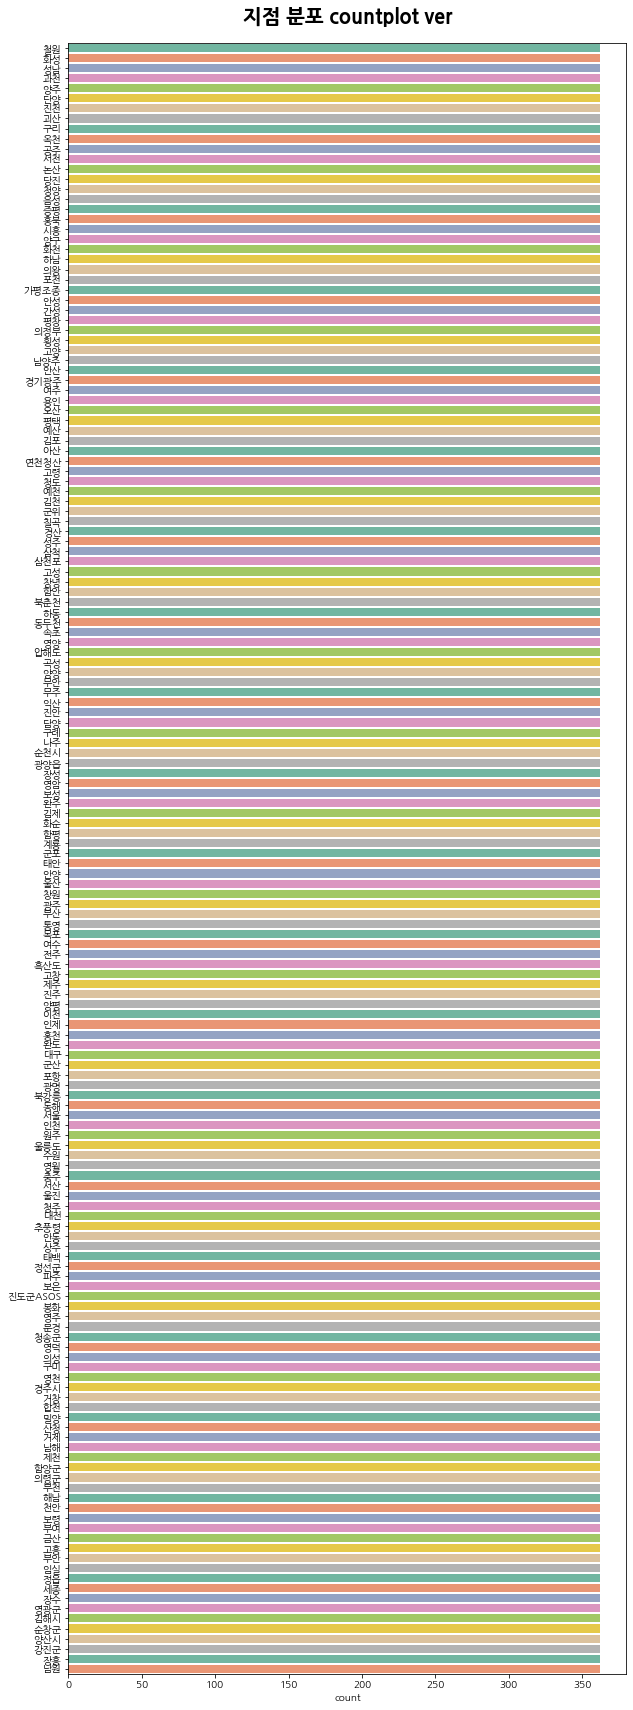

In [6]:
plt.figure(figsize=(10,30))
sns.countplot(y=data['지점'], palette=sns.color_palette('Set2', n_colors=data['지점'].nunique()))
plt.title('지점 분포 countplot ver', fontsize=20, pad=20, fontweight='bold')
plt.ylabel('')

↑누락된 날짜, 지점은 없는 것으로 해석

In [189]:
# NaN값들을 지점 별로 value_counts(), unstack()한 table ==> 시각화 하기 위해서
# 각 값들은 NaN값의 개수를 나타낸 것

humid = data.groupby('지점')['평균상대습도(%)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균상대습도(%)')
sensory = data.groupby('지점')['최고체감온도(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고체감온도(°C)')
low = data.groupby('지점')['최저기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최저기온(°C)')
high = data.groupby('지점')['최고기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='최고기온(°C)')
mean = data.groupby('지점')['평균기온(°C)'].value_counts(dropna=False).unstack().fillna(0).iloc[:,0].reset_index(name='평균기온(°C)')

null_table = humid.merge(sensory, how='left', on='지점').merge(low, how='left', on='지점').merge(high, how='left', on='지점').merge(mean, how='left', on='지점').set_index('지점')

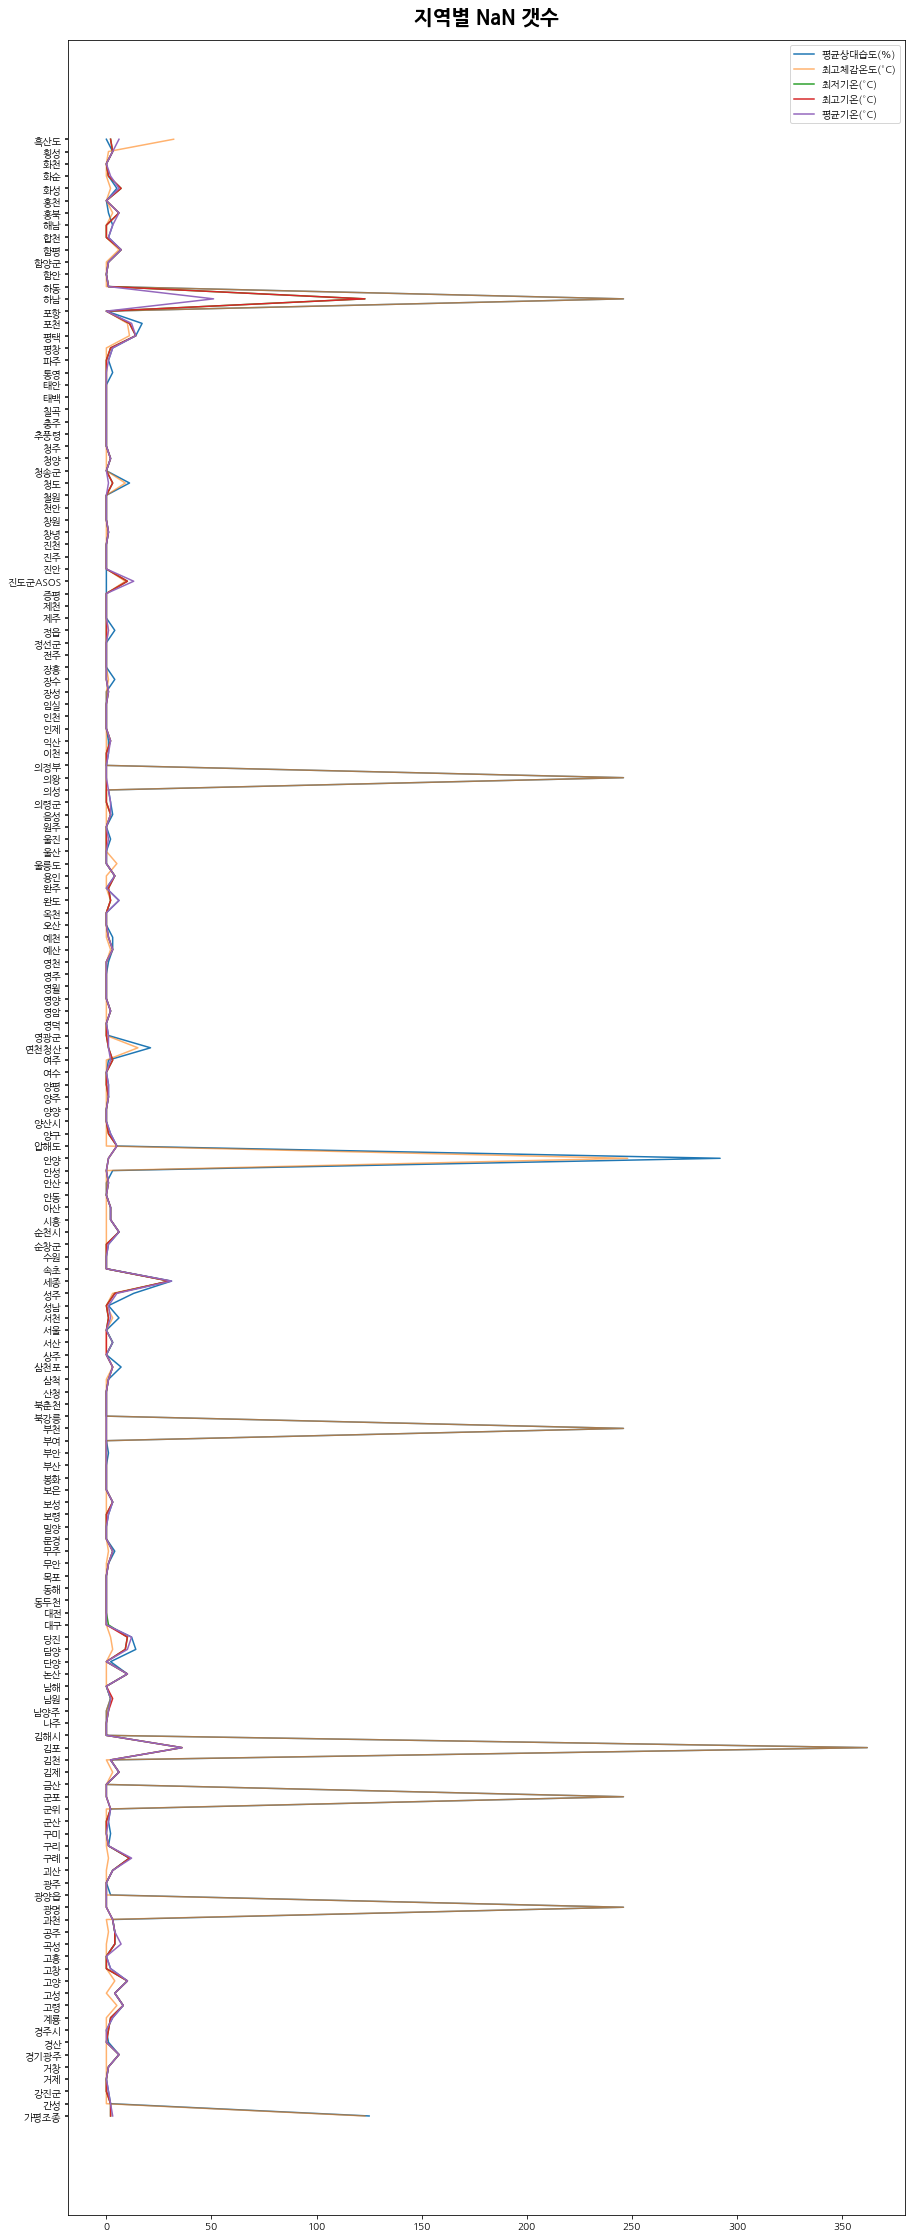

In [ ]:
plt.figure(figsize=(15,40))
plt.plot(null_table['평균상대습도(%)'], null_table.index, label='평균상대습도(%)')
plt.plot(null_table['최고체감온도(°C)'], null_table.index, label='최고체감온도(°C)', alpha=0.6)
plt.plot(null_table['최저기온(°C)'], null_table.index, label='최저기온(°C)')
plt.plot(null_table['최고기온(°C)'], null_table.index, label='최고기온(°C)')
plt.plot(null_table['평균기온(°C)'], null_table.index, label='평균기온(°C)') 
plt.title('지역별 NaN 갯수', fontsize=20, pad=18, fontweight='bold')
plt.legend()
plt.tick_params(axis='y', width=1.5)

하남에서는 전체적으로 누락값이 많이 관측되고 [의왕, 안양, 부천, 김포, 군포, 광명, 가평조종]에서는 '최고체감온도', '평균상대습도'가 비슷하게 누락값이 많이 관찰된다.



# 2. 시각화 : 기온(°C) EDA

In [ ]:
sns.color_palette('RdBu')

[(0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
 (0.940715109573241, 0.6099192618223759, 0.4812764321414839),
 (0.9856978085351787, 0.8889657823913879, 0.8320645905420992),
 (0.8605151864667436, 0.9174163783160324, 0.9487120338331411),
 (0.530026912725875, 0.7456362937331797, 0.8560553633217994),
 (0.1843137254901961, 0.47266435986159167, 0.7116493656286044)]

Text(0.5, 1.0, '평균상대습도(%)(Bar ver)')

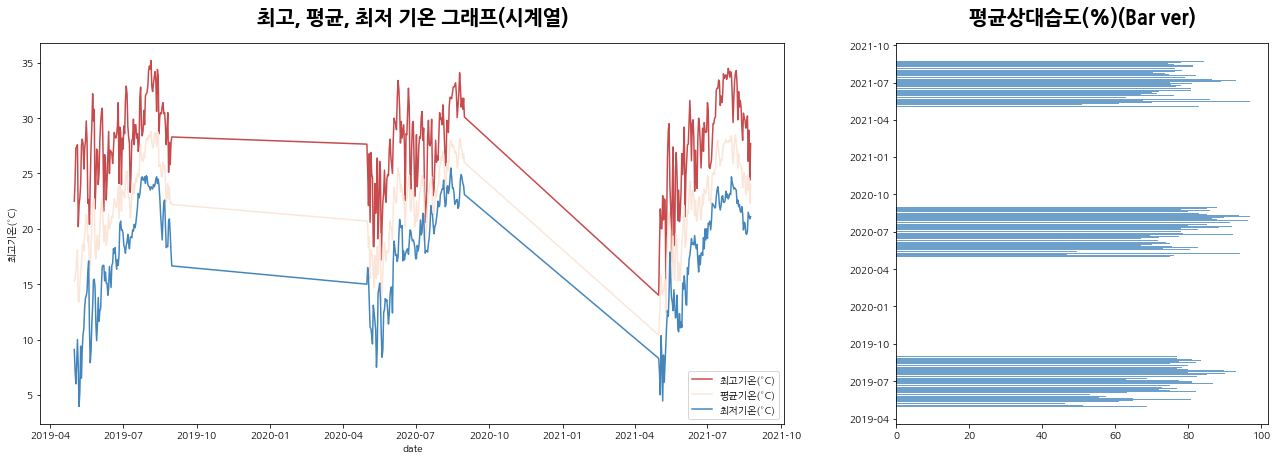

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(22,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=data.groupby(['date'])['최고기온(°C)'].median().index, y=data.groupby(['date'])['최고기온(°C)'].median(), color=sns.color_palette('RdBu')[0], label='최고기온(°C)', ax=ax[0], alpha=0.9)
sns.lineplot(x=data.groupby(['date'])['평균기온(°C)'].median().index, y=data.groupby(['date'])['평균기온(°C)'].median(), color=sns.color_palette('RdBu')[2], label='평균기온(°C)', ax=ax[0], alpha=0.9)
sns.lineplot(x=data.groupby(['date'])['최저기온(°C)'].median().index, y=data.groupby(['date'])['최저기온(°C)'].median(), color=sns.color_palette('RdBu')[5], label='최저기온(°C)', ax=ax[0], alpha=0.9)
ax[0].set_title('최고, 평균, 최저 기온 그래프(시계열)', fontsize=20, fontweight='bold', pad=20)

plt.barh(data.groupby(['date'])['평균상대습도(%)'].median().index, data.groupby(['date'])['평균상대습도(%)'].median(), color=sns.color_palette('RdBu')[5], alpha=0.7)
plt.title('평균상대습도(%)(Bar ver)', fontsize=20, fontweight='bold', pad=20)


In [190]:
# 연도별로 시각화 하기 위한 전처리
data['월-일'] = data['date'].astype('string').apply(lambda x: x[5:])

year_2019 = data.loc[data['year'] == 2019]
year_2020 = data.loc[data['year'] == 2020]
year_2021 = data.loc[data['year'] == 2021]

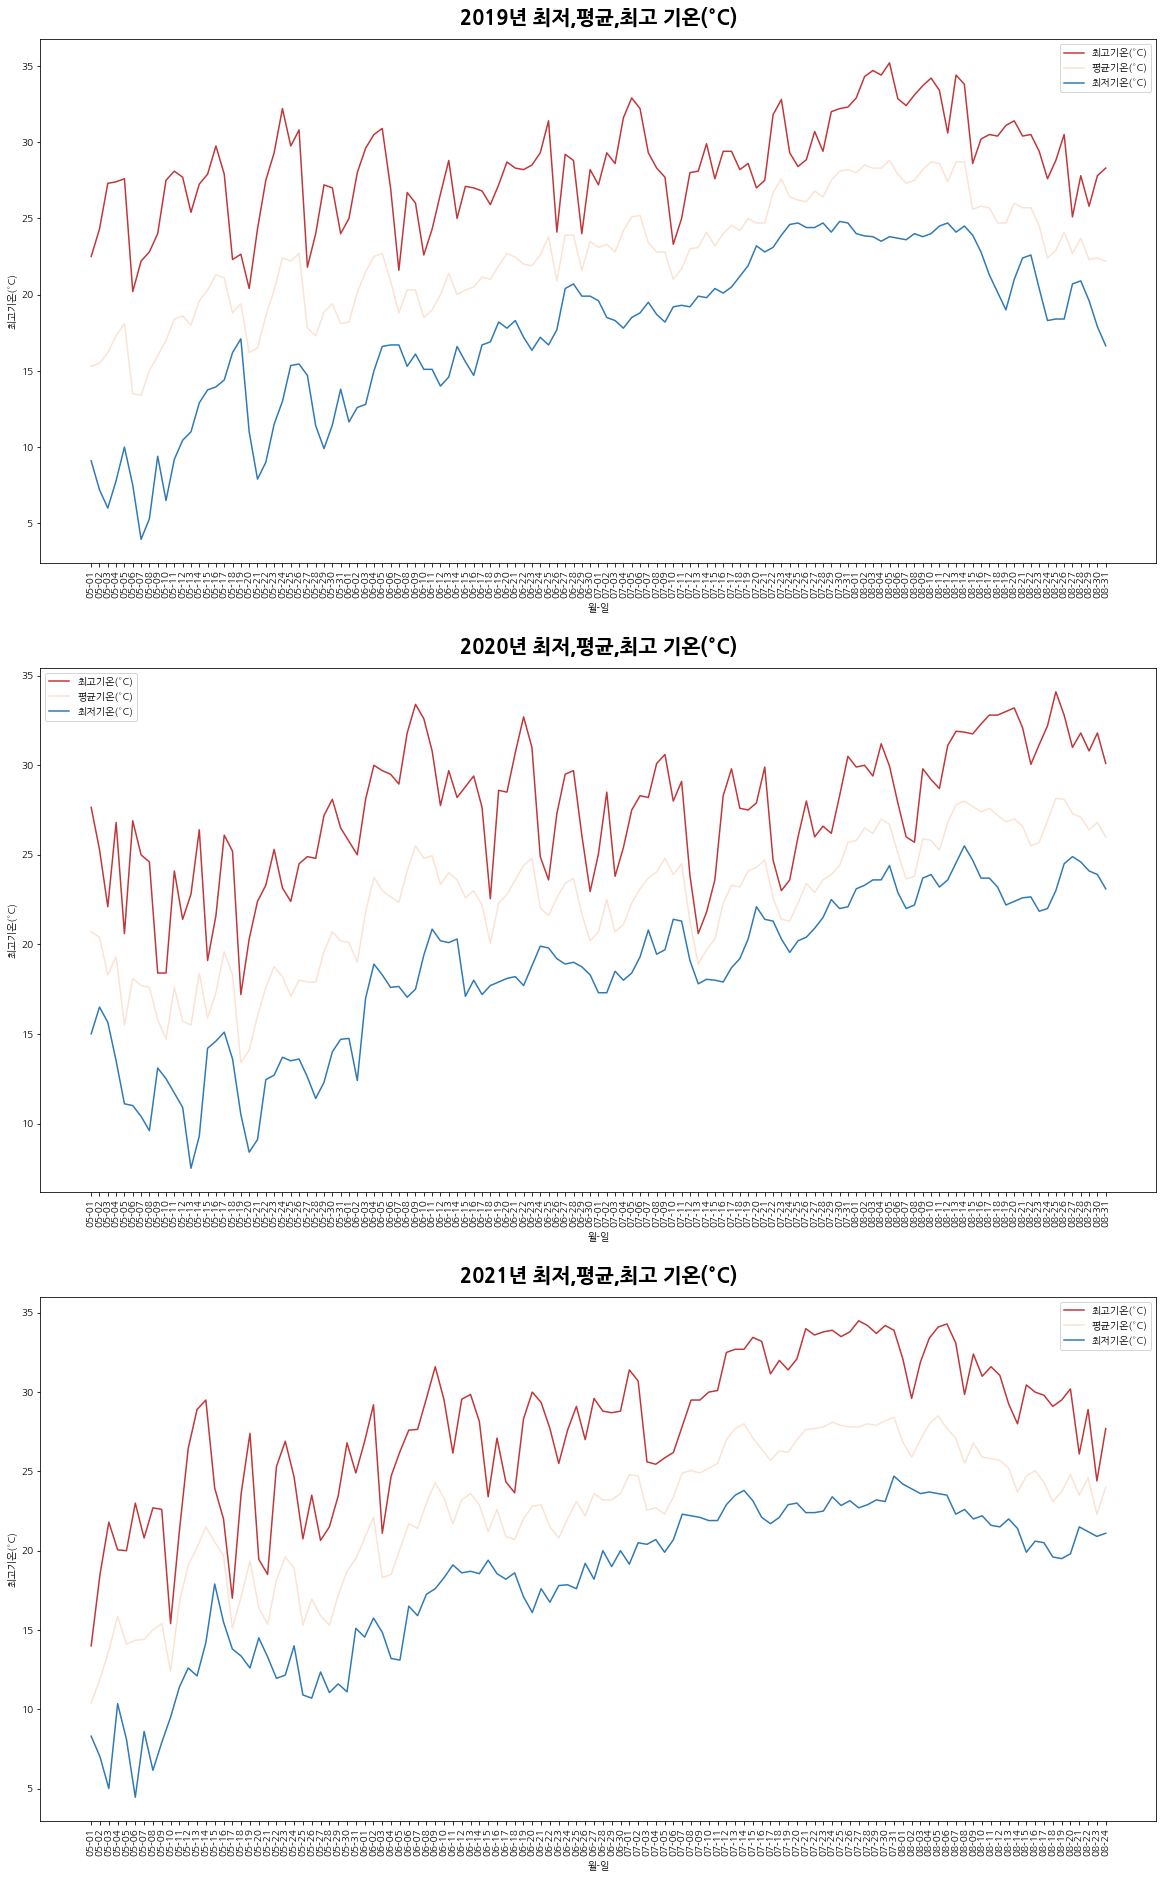

In [ ]:
plt.figure(figsize=(20, 18))
for j,i in enumerate([year_2019, year_2020, year_2021]):
  plt.subplot(3,1, j+1)
  sns.lineplot(x=i.groupby('월-일')['최고기온(°C)'].median().index, y=i.groupby('월-일')['최고기온(°C)'].median(), color=sns.color_palette('RdBu')[0], label='최고기온(°C)')
  sns.lineplot(x=i.groupby('월-일')['평균기온(°C)'].median().index, y=i.groupby('월-일')['평균기온(°C)'].median(), color=sns.color_palette('RdBu')[2], label='평균기온(°C)')
  sns.lineplot(x=i.groupby('월-일')['최저기온(°C)'].median().index, y=i.groupby('월-일')['최저기온(°C)'].median(), color=sns.color_palette('RdBu')[5], label='최저기온(°C)')
  plt.xticks(rotation=90)
  plt.title(f"{i['year'].mode()[0]}년 최저,평균,최고 기온(°C)", fontsize=20, pad=15, fontweight='bold')

plt.subplots_adjust(top=1.5)

In [ ]:
sns.color_palette("gist_heat")

[(0.21176470588235294, 0.0, 0.0),
 (0.4294117647058823, 0.0, 0.0),
 (0.6411764705882352, 0.0, 0.0),
 (0.8588235294117647, 0.1450980392156862, 0.0),
 (1.0, 0.4274509803921569, 0.0),
 (1.0, 0.7176470588235293, 0.4352941176470586)]

Text(0.5, 1.0, '연도별 평균기온(°C) 비교')

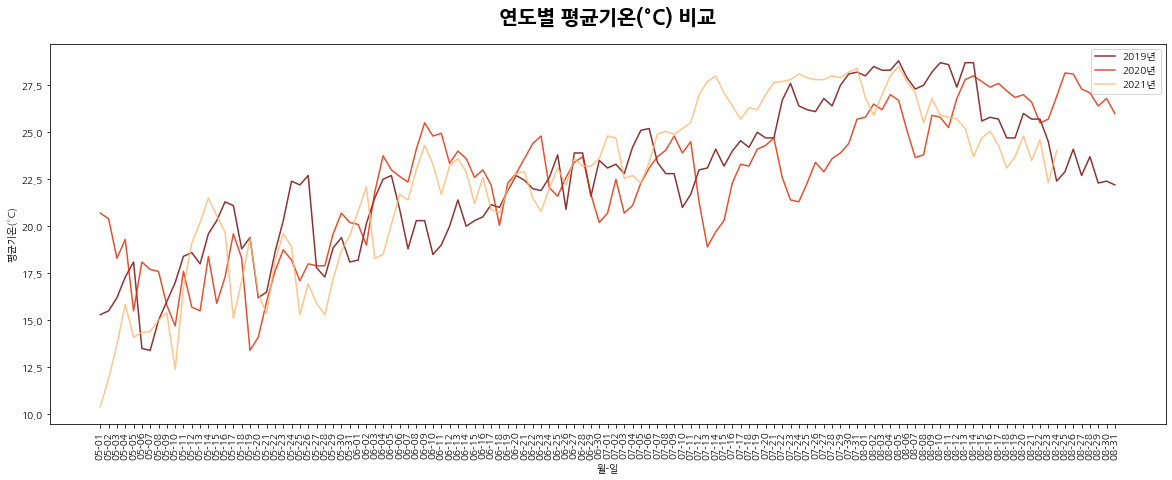

In [ ]:
plt.subplots(figsize=(20, 7))
sns.lineplot(x=year_2019.groupby('월-일')['평균기온(°C)'].median().index, y=year_2019.groupby('월-일')['평균기온(°C)'].median(), color=sns.color_palette("gist_heat")[1], label='2019년', alpha=0.8)
sns.lineplot(x=year_2020.groupby('월-일')['평균기온(°C)'].median().index, y=year_2020.groupby('월-일')['평균기온(°C)'].median(), color=sns.color_palette("gist_heat")[3], label='2020년', alpha=0.8)
sns.lineplot(x=year_2021.groupby('월-일')['평균기온(°C)'].median().index, y=year_2021.groupby('월-일')['평균기온(°C)'].median(), color=sns.color_palette("gist_heat")[5], label='2021년', alpha=0.8)

plt.xticks(rotation=90)
plt.title('연도별 평균기온(°C) 비교', fontsize=20, pad=20, fontweight='bold')
# 연도별 기온 비교는 시각화가 복잡해지기 때문에 plotly로 해야 할 것 같다.

Text(0.5, 1.0, '연도별 평균기온 분포 그래프(strip ver)-2021s 포함')

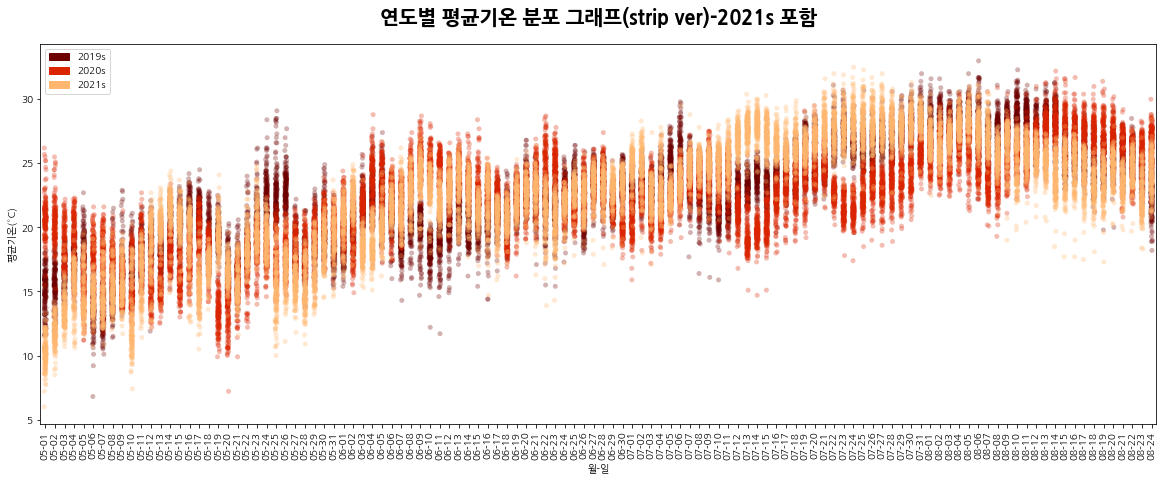

In [ ]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(20,7))
sns.stripplot(x=year_2019['월-일'], y=year_2019['평균기온(°C)'], color=sns.color_palette("gist_heat")[1], alpha=0.3)
sns.stripplot(x=year_2020['월-일'], y=year_2020['평균기온(°C)'], color=sns.color_palette("gist_heat")[3], alpha=0.3)
sns.stripplot(x=year_2021['월-일'], y=year_2021['평균기온(°C)'], color=sns.color_palette("gist_heat")[5], alpha=0.3)


patch1 = mpatches.Patch(color=sns.color_palette("gist_heat")[1], label='2019s')
patch2 = mpatches.Patch(color=sns.color_palette("gist_heat")[3], label='2020s')
patch3 = mpatches.Patch(color=sns.color_palette("gist_heat")[5], label='2021s')
plt.legend(handles=(patch1, patch2, patch3))
plt.xticks(rotation=90)
plt.title('연도별 평균기온 분포 그래프(strip ver)-2021s 포함', fontsize=20, pad=20, fontweight='bold')

# 연도별 시각화(visualization)로 얻을 수 있는 결론

- 7,8월이 될수록 기온은 높아져 간다.(당연하겠지...)

- 5,6월 최고기온이 30도 이내 일때도 있었다. 하지만 최저기온은 낮아서 평균 온도는 낮았다.

- 2020년은 2019, 2021년과 다르게 month별 평균기온의 차이가 상대적으로 적다.
 - 외부 요인이 작용했을 수도 있다.(강수량, 기압분포...)

- 2019년의 7월 기온을 살펴 보면...
 - 2019년 7월 초 : 평균 기온 19-25도 분포 ==> 낮 기온이 30도를 넘기 시작했지만 저녁에는 시원하기 때문에 살만하다.
 - 2019년 7월 중 : 평균 기온 20-25도 분포 ==> 더위가 슬슬 시작되었다.
 - 2019년 7월 말 : 평균 기온 25-30도 분포 ==> 폭염이 시작 되었다.

- 2020년의 7월 기온을 살펴 보면...
 - 2020년 7월 초 : 15-25도 분포 ==> 2019년도와 비슷하지만 낮 기온이 30도를 넘지 않는다.
 - 2020년 7월 중 : 15-23도 분포 ==> 2019년에 비해 더위가 시작 되지 않고, 낮 기온도 아직 30도를 넘지 않는다.
 - 2020년 7월 말 : 18-25도 분포 ==> 2019년 7월 말은 폭염이 시작되었는데 2020년은 더위가 시작 되지도 않았음.

- 2019년 8월 기온을 살펴보면...
 - 2019년 8월 초 : 평균 기온이 25-33도 분포(지역차) ==> 폭염의 절정
 - 2019년 8월 중 : 평균 기온이 23-28도 분포 ==>  더위가 한 풀 꺾임. 하지만 최고기온 30도를 찍을 만큼 낮에는 덥다.
 - 2019년 8월 말 : 평균 기온이 18-23도 분포 ==> 더위가 완전 가심, 최저기온이 15도를 찍을 정도로 기온이 낮아졌다.(초가을)
 - 결론 : 2019년 여름은 전형적인 우리나라 여름 날씨 

- 2020년 8월 기온을 살펴보면...
 - 2020년 8월 초 : 2019년에 비해 3-4도 가량 평균 기온이 낮다.
 - 2020년 8월 중 : 2019년에 비해 1-2도 가량 평균 기온이 높다.(원래라면 8월 중순에는 기온이 내려가야 되는데 오히려 최고 기온을 찍었다.)
 - 2020년 8월 말 : 2019년에 비해 5-6도 가량 평균 기온이 높다.
 - 결론 : 이상기후(?) 2020년은 다른 해와 다르게 7월말과 8월초에 기온이 낮았다, 하지만 8월 중순부터 본격적인 더위(폭염)가 시작되었다.

- **2021년 7월 초까지는 2019, 2020년과 비슷한 기온이었는데, 2021년 7월 중순 부터 폭염이 시작됨** 




# 2. 시각화 : 지역별 EDA

Text(0.5, 1.0, '지점(지역)별 기온 - 평균기온(°C)으로 sort')

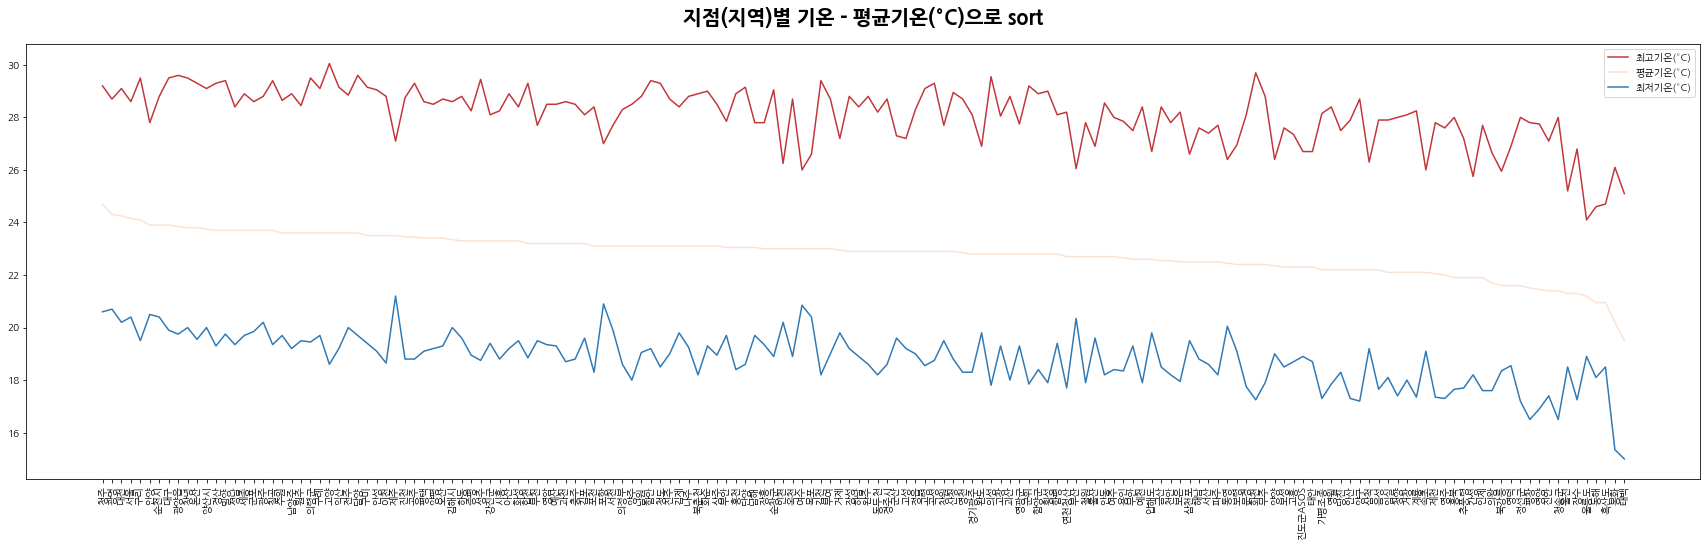

In [ ]:
# 평균기온 별로 sort 보기 편하려고
city = data.groupby('지점')[['최고기온(°C)', '평균기온(°C)', '최저기온(°C)']].median().sort_values(by='평균기온(°C)', ascending=False)

plt.figure(figsize=(30,8))
plt.plot(city.index, city['최고기온(°C)'], label='최고기온(°C)', color=sns.color_palette('RdBu')[0])
plt.plot(city.index, city['평균기온(°C)'], label='평균기온(°C)', color=sns.color_palette('RdBu')[2])
plt.plot(city.index, city['최저기온(°C)'], label='최저기온(°C)', color=sns.color_palette('RdBu')[5])
plt.legend()
plt.xticks(rotation=90)
plt.title('지점(지역)별 기온 - 평균기온(°C)으로 sort', fontsize=20, pad=20, fontweight='bold')

Text(0.5, 1.0, 'year(연도)로 구별한 지점 기온')

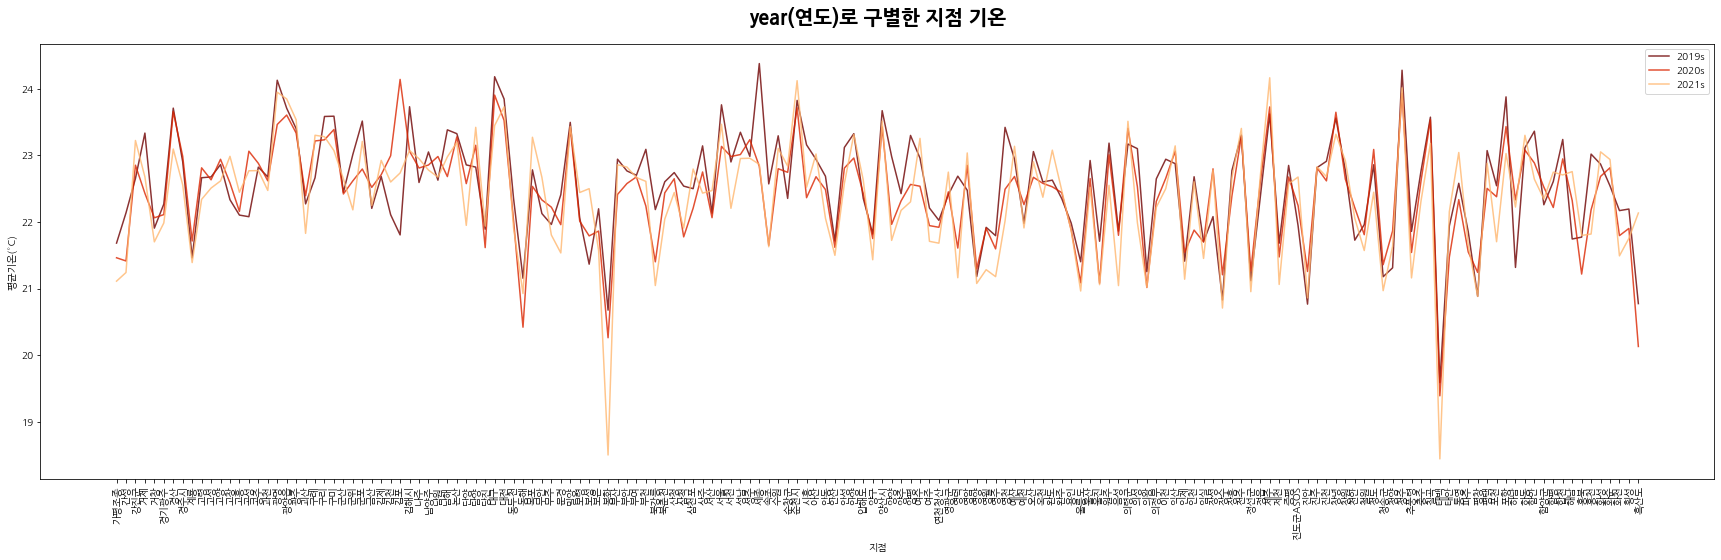

In [ ]:
# c_y = data.groupby(['지점', 'year'])['평균기온(°C)'].median().reset_index().sort_values(by='평균기온(°C)', ascending=False)

plt.figure(figsize=(30,8))
# sns.lineplot(x=c_y['지점'], y=c_y['평균기온(°C)'], hue=c_y['year'], palette=sns.color_palette("gist_heat", n_colors=len(c_y['year'].unique())))
sns.lineplot(x=year_2019.groupby('지점')['평균기온(°C)'].mean().index, y=year_2019.groupby('지점')['평균기온(°C)'].mean(), label='2019s', color=sns.color_palette("gist_heat")[1], alpha=0.8)
sns.lineplot(x=year_2020.groupby('지점')['평균기온(°C)'].mean().index, y=year_2020.groupby('지점')['평균기온(°C)'].mean(), label='2020s', color=sns.color_palette("gist_heat")[3], alpha=0.8)
sns.lineplot(x=year_2021.groupby('지점')['평균기온(°C)'].mean().index, y=year_2021.groupby('지점')['평균기온(°C)'].mean(), label='2021s', color=sns.color_palette("gist_heat")[5], alpha=0.8)
plt.xticks(rotation=90)
plt.title('year(연도)로 구별한 지점 기온', fontsize=20, pad=20, fontweight='bold')
# 2021년 8월 기온이 아직 반영이 안되었다.

Text(0.5, 1.0, '월(month)로 구별한 지점별 평균기온')

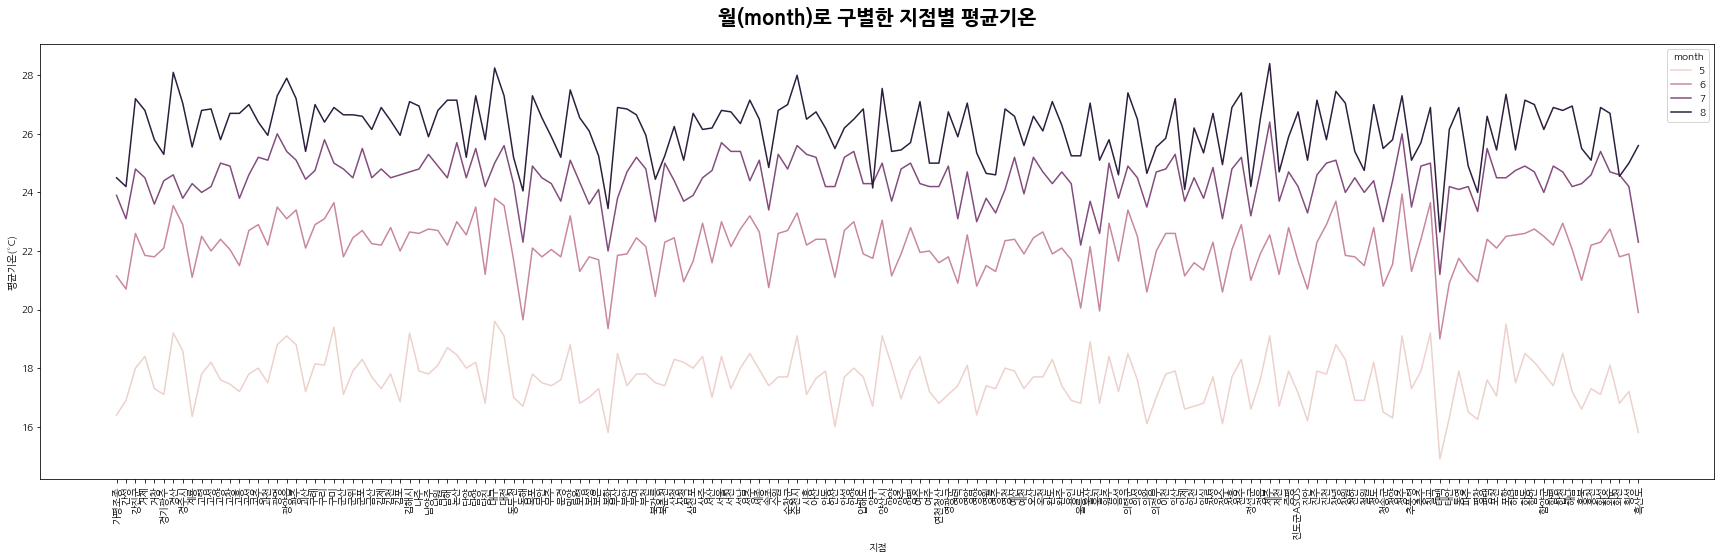

In [ ]:
plt.subplots(figsize=(30,8))
sns.lineplot(x=data.groupby(['지점', 'month'])['평균기온(°C)'].median().reset_index()['지점'], y=data.groupby(['지점', 'month'])['평균기온(°C)'].median().reset_index()['평균기온(°C)'], hue=data.groupby(['지점', 'month'])['평균기온(°C)'].median().reset_index()['month'])
plt.xticks(rotation=90)
plt.title('월(month)로 구별한 지점별 평균기온', fontsize=20, pad=20, fontweight='bold')

In [ ]:
data.groupby(['지점'])[['최고기온(°C)','평균기온(°C)','최저기온(°C)']].median().reset_index().sort_values(by='최고기온(°C)', ascending=False).reset_index(drop=True).style.bar(subset=['최저기온(°C)'], color='#205ff2').background_gradient(subset=['최고기온(°C)'], cmap='coolwarm')

,지점,최고기온(°C),평균기온(°C),최저기온(°C)
0,고양,30.050000,23.600000,18.600000
1,화천,29.700000,22.400000,17.250000
2,담양,29.600000,23.600000,19.700000
3,광양읍,29.600000,23.850000,19.750000
4,의성,29.550000,22.800000,17.800000
5,의령군,29.500000,23.600000,19.450000
6,구리,29.500000,24.100000,19.500000
7,창녕,29.500000,23.800000,20.000000
8,대구,29.500000,23.900000,19.900000
9,성주,29.450000,23.300000,18.750000


# plotly ver

In [ ]:
!pip install plotly.express

In [ ]:
# 지점이 너무 많다 보니 정적 그래프는 좀 해석이 어렵다 판단하여 plotly
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=city.index, y=city['최고기온(°C)'], name = '최고기온(°C)',
                         line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=city.index, y=city['평균기온(°C)'], name = '평균기온(°C)',
                         line=dict(color='rosybrown', width=2)))
fig.add_trace(go.Scatter(x=city.index, y=city['최저기온(°C)'], name = '최저기온(°C)',
                         line=dict(color='royalblue', width=2)))

fig.update_layout(title='지점(지역)별 기온 - plotly ver',
                   xaxis_title='지점',
                   yaxis_title='기온(°C)',)

In [ ]:
c_m = data.groupby(['지점', 'month'])['평균기온(°C)'].median().reset_index()

px.line(data_frame=c_m, x='지점', y='평균기온(°C)', color='month', color_discrete_sequence=px.colors.qualitative.Antique, title='월(month)로 구별한 지점별 평균기온-plotly ver')

# 지역별 시각화 결론
 
 - 2019년 보다 2020년의 평균 기온이 대부분의 지역에서 낮다.(1~3도 가량)

 - 육지에서 멀리 떨어져있는 섬(흑산도, 울릉도...)이거나 영동지방은 7월 최고 기온이 23~26도 일정도로 시원하다.
  - 여름 휴가는 이런 곳으로 가야한다...

 - 제주, 대구, 경산, 대구, 서울... 순으로 7,8월 최고 기온이 28~29도로 덥다.




# 2. 시각화 : 체감기온(°C)의 상관계수

- 체감온도 = 13.12 + 0.6215 * T - 11.37 * V * 0.16 + 0.3965 * V * 0.16 * T
    * T : 기온((°C)), V : 풍속(km/h)

Text(0.5, 1.0, '최고체감온도 vs 평균상대습도 scatter, Correlation:0.21627916410285514')

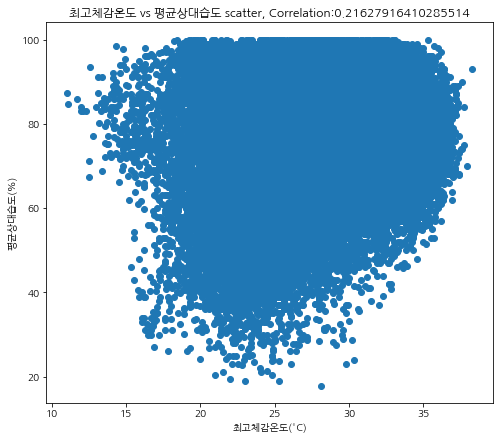

In [ ]:
# 우선 상관계수를 살펴보자
corr = data['최고체감온도(°C)'].corr(data['평균상대습도(%)'])
plt.figure(figsize=(8,7))
plt.scatter(data['최고체감온도(°C)'], data['평균상대습도(%)'])
plt.xlabel('최고체감온도(°C)')
plt.ylabel('평균상대습도(%)')
plt.title(f'최고체감온도 vs 평균상대습도 scatter, Correlation:{corr}')

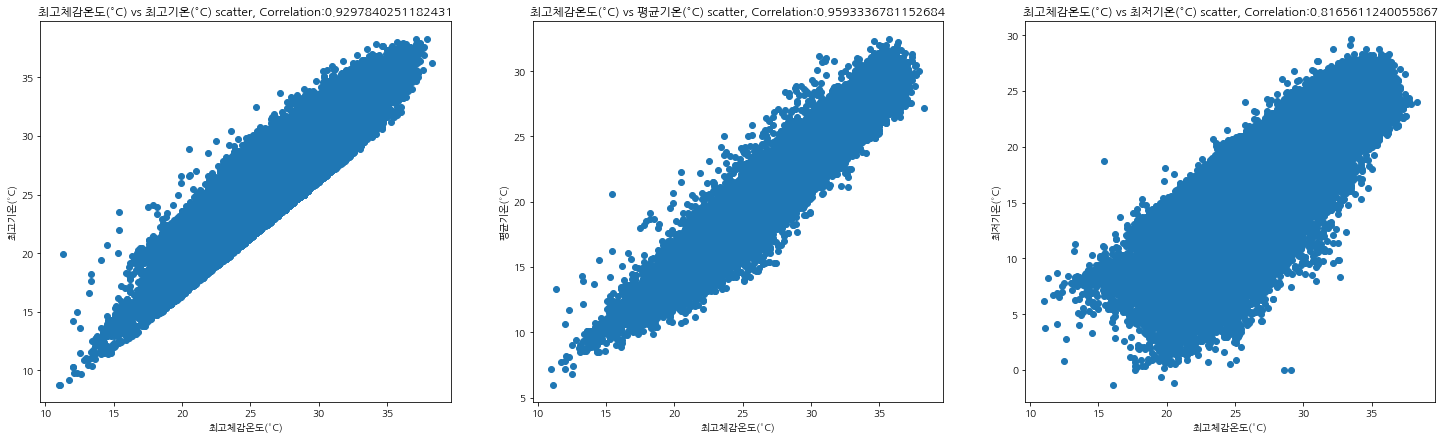

In [ ]:
fig = plt.figure(figsize=(25,7))
for j, i in enumerate(['최고기온(°C)', '평균기온(°C)', '최저기온(°C)']):
  corr = data['최고체감온도(°C)'].corr(data[i])
  plt.subplot(1,3, j+1)
  plt.scatter(data['최고체감온도(°C)'], data[i])
  plt.xlabel('최고체감온도(°C)')
  plt.ylabel(f'{i}')
  plt.title(f'최고체감온도(°C) vs {i} scatter, Correlation:{corr}')

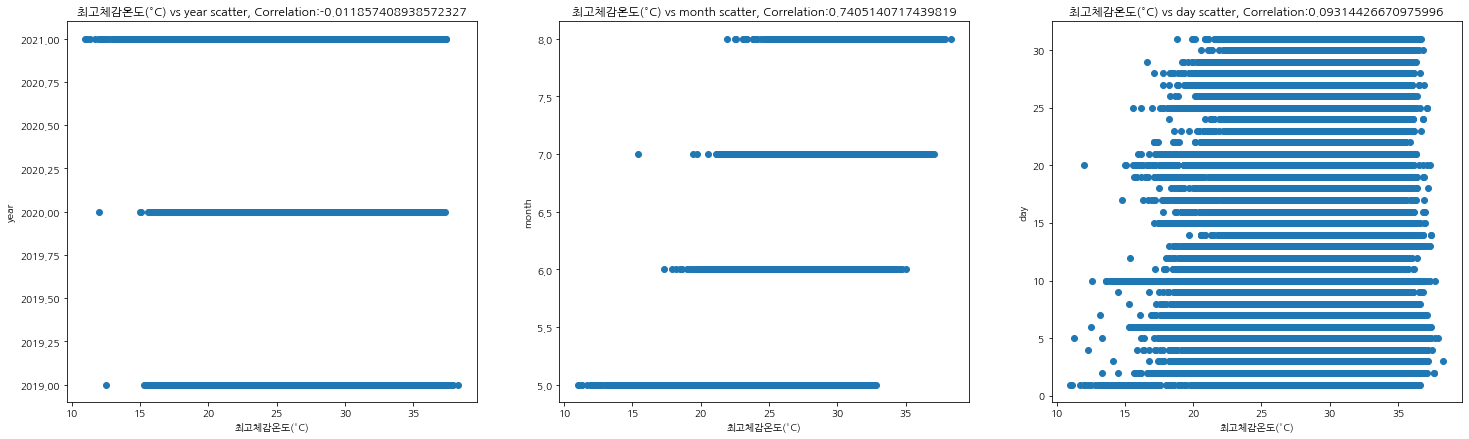

In [ ]:
# 시계열 corr
fig = plt.figure(figsize=(25,7))
for j, i in enumerate(['year', 'month', 'day']):
  corr = data['최고체감온도(°C)'].corr(data[i])
  plt.subplot(1,3, j+1)
  plt.scatter(data['최고체감온도(°C)'], data[i])
  plt.xlabel('최고체감온도(°C)')
  plt.ylabel(f'{i}')
  plt.title(f'최고체감온도(°C) vs {i} scatter, Correlation:{corr}')

# 체감온도의 고찰

- 열대야에 주요한 지수인 체감온도는 평균상대습도(%)보다 기온(°C)에 더 영향을 받는다.

  - 최고기온(°C)과 corr = 0.929, 평균기온(°C)과 corr = 0.959, 최소기온(°C)과 corr = 0.816 일정도로 correlation이 높다.

  - 반면 평균상대습도(%)의 corr = 0.216으로 기온(°C)과 비교해서 현저히 낮다.

- 체감온도와 시계열 변수의 corr : year corr=-0.011, month corr=0.745, day corr=0.093
    - month의 corr가 높다 ==> 체감온도는 month(월)의 영향을 받는다.(당연하겠지...)


> 결론 : 체감온도(°C)는 습도보다는 기온, month에 영향을 많이 받음(corr 0.6 이상 차이가 난다.)




# 3. 누락 값 처리(Feature Engineering)

In [191]:
# 각 컬럼의 NaN 나타내는 테이블(table)-야매ver
data_isnull = data.isnull().sum().reset_index(name='count')
data_nullmean = data.isnull().mean().reset_index(name='percent')

data_isnull_table = data_isnull.merge(data_nullmean, how='left', on='index').set_index('index').sort_values('percent', ascending=False) 
data_isnull_table
# 폭염영향예보(단계) 누락 값(NaN)은 ' '이다.

,count,percent
index,,
평균상대습도(%),2358,0.040209
폭염영향예보(단계),2259,0.038521
최고체감온도(°C),2133,0.036372
최저기온(°C),425,0.007247
최고기온(°C),422,0.007196
평균기온(°C),393,0.006701
일시,0,0.000000
year,0,0.000000
date,0,0.000000


In [9]:
for i,j,k in zip(data['지점'], data['month'], data['day']):
  data.loc[(data['지점']==i) & (data['평균상대습도(%)'].isnull()) & (data['month']==j) & (data['day']==k), '평균상대습도(%)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['평균상대습도(%)'].mean()
  data.loc[(data['지점']==i) & (data['최저기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '최저기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['최저기온(°C)'].mean()
  data.loc[(data['지점']==i) & (data['최고기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '최고기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['최고기온(°C)'].mean()
  data.loc[(data['지점']==i) & (data['평균기온(°C)'].isnull()) & (data['month']==j) & (data['day']==k), '평균기온(°C)'] = data.loc[(data['month']==j) & (data['day']==k) & (data['지점']==i)]['평균기온(°C)'].mean()

  data.loc[(data['지점']==i) & (data['평균상대습도(%)'].isnull()) & (data['month']==j) & (data['day']==k), '평균상대습도(%)'] = data.loc[(data['month']==j) & (data['day']==k)]['평균상대습도(%)'].median()

In [10]:
data['최고체감온도(°C)'] = data['최고체감온도(°C)'].fillna(data['최고기온(°C)'])

In [14]:
data['폭염영향예보(단계)'] = data['폭염영향예보(단계)'].replace(' ', '평시')
data['폭염영향예보(단계)'] = data['폭염영향예보(단계)'].fillna('평시')
data['폭염영향예보(단계)'].value_counts()

평시    37856
주의     7001
관심     6948
경고     4569
심각       11
Name: 폭염영향예보(단계), dtype: int64

# 누락 값 처리 완료 
- 처리 방법
 - 지점 별로 지난 month, day별 mean값으로 치환
 - '최고체감온도(°C)'컬럼의 누락 값은 그 날의 최고기온으로 치환
 - 전체 기간이 누락된 값은 전체 지점의 median값으로 치환


# 4. Modeling

- Target 변수 = '폭염여부(O/X)'

- 사용 모델 : Catboost, lightgbm, xgboost, RandomForest

- 사용 Scaling : MinMaxScaler, StandardScaler

- 사용 Encoder : LabelEncoder, OnehotEncoding ==> Catboost는 Encoding을 안하겠습니다.

In [ ]:
!pip install catboost
!pip install optuna
import catboost
import optuna
import lightgbm
import xgboost
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [27]:
# Heatmap전 Encoder
data_copy = data.copy()
for i in data.select_dtypes('object').columns:
  data_copy[i] = LabelEncoder().fit_transform(data[i])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 1.0, 'Train Set Correalation')

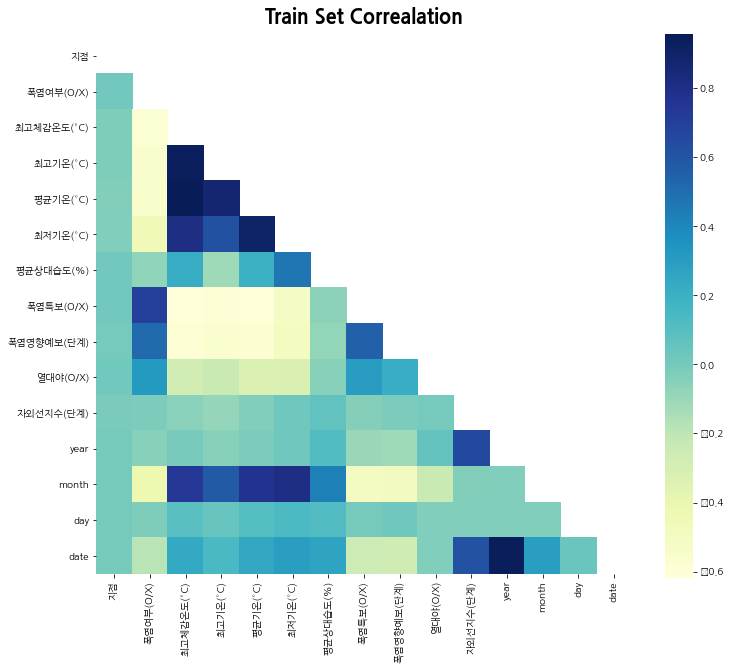

In [29]:
# HeatMap
mask = np.triu(np.ones_like(data_copy.corr(), dtype=np.bool))
plt.figure(figsize=(12,10))
sns.heatmap(data_copy.corr(), cmap='YlGnBu', cbar=True, square=True, mask=mask)
plt.title('Train Set Correalation', fontsize=20, pad=15, fontweight='bold')

In [45]:
# Data Split
x_train = data.drop(columns=['일시', '폭염여부(O/X)', 'date'])
y_train = data['폭염여부(O/X)']

In [46]:
# Scaling
for i in x_train.select_dtypes(exclude='object').columns:
  x_train[i] = StandardScaler().fit_transform(x_train[[i]])

In [61]:
# 분류 metrics
def metrics_classification(model, X_valid, Y_valid, val_preds):
  confusion = plot_confusion_matrix(model, X_valid, Y_valid, cmap='YlGnBu')
  print(classification_report(Y_valid, val_preds))
  return confusion

# Catboost

In [76]:
cat_features = list(x_train.select_dtypes('object').columns)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(iterations=5000, learning_rate=0.022, eval_metric='AUC', cat_features=cat_features)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  val_preds = model_cat.predict(X_valid)

0:	test: 0.9989772	best: 0.9989772 (0)	total: 58.9ms	remaining: 4m 54s
100:	test: 1.0000000	best: 1.0000000 (34)	total: 4.83s	remaining: 3m 54s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 1
bestIteration = 34

Shrink model to first 35 iterations.
0:	test: 0.9991177	best: 0.9991177 (0)	total: 57ms	remaining: 4m 45s
100:	test: 0.9999681	best: 0.9999687 (98)	total: 4.5s	remaining: 3m 38s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.9999686674
bestIteration = 98

Shrink model to first 99 iterations.
0:	test: 0.9990134	best: 0.9990134 (0)	total: 55.9ms	remaining: 4m 39s
100:	test: 0.9999803	best: 0.9999803 (99)	total: 4.6s	remaining: 3m 43s
200:	test: 0.9999893	best: 0.9999897 (165)	total: 8.94s	remaining: 3m 33s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.9999901146
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.9989765	best: 0.9989765 (0)	total: 57.2ms	remaining: 4m 45s
100:	test: 0.9999888	best: 0

              precision    recall  f1-score   support

           O       1.00      1.00      1.00      1729
           X       1.00      1.00      1.00      9999

    accuracy                           1.00     11728
   macro avg       1.00      1.00      1.00     11728
weighted avg       1.00      1.00      1.00     11728



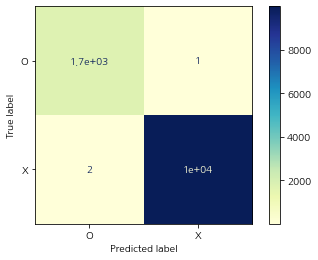

In [77]:
metrics_classification(model_cat, X_valid, Y_valid, val_preds)

# XGBoost

In [146]:
x_train = data.drop(columns=['일시', '폭염여부(O/X)', 'date'])
y_train = data['폭염여부(O/X)']

for i in x_train.select_dtypes('object').columns:
  if x_train[i].nunique() < 3:
    x_train[i] = LabelEncoder().fit_transform(x_train[i])
  else:
    x_train = pd.get_dummies(x_train, columns=[i])

x_train_columns = x_train.columns

x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x_train_columns)

sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(iterations=5000, learning_rate=0.022, eval_metric='auc')
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  val_preds = model_xgb.predict(X_valid)

[0]	validation_0-auc:0.998875	validation_1-auc:0.9991
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 70 rounds.
[99]	validation_0-auc:0.999806	validation_1-auc:0.999893
[0]	validation_0-auc:0.999008	validation_1-auc:0.999047
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 70 rounds.
[99]	validation_0-auc:0.999903	validation_1-auc:0.999945
[0]	validation_0-auc:0.998925	validation_1-auc:0.9989
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 70 rounds.
[99]	validation_0-auc:0.999735	validation_1-auc:0.999646
[0]	validation_0-auc:0.999	validation_1-auc:0.99855
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved

              precision    recall  f1-score   support

           O       0.98      1.00      0.99      1729
           X       1.00      1.00      1.00      9999

    accuracy                           1.00     11728
   macro avg       0.99      1.00      1.00     11728
weighted avg       1.00      1.00      1.00     11728



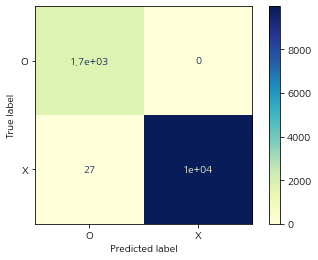

In [147]:
metrics_classification(model_xgb, X_valid, Y_valid, val_preds)

# Lightgbm

In [154]:
x_train = data.drop(columns=['일시', '폭염여부(O/X)', 'date'])
y_train = data['폭염여부(O/X)']

for i in x_train.select_dtypes('object').columns:
  if x_train[i].nunique() < 3:
    x_train[i] = LabelEncoder().fit_transform(x_train[i])
  else:
    x_train = pd.get_dummies(x_train, columns=[i])

x_train_columns = x_train.columns

x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x_train_columns)

sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgbm = lightgbm.LGBMClassifier(iterations=5000, learning_rate=0.022, metrics='AUC')
  model_lgbm.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  val_preds = model_lgbm.predict(X_valid)

Training until validation scores don't improve for 70 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.999956
Training until validation scores don't improve for 70 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.999951
Training until validation scores don't improve for 70 rounds.
[100]	valid_0's auc: 0.999915
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.999916
Training until validation scores don't improve for 70 rounds.
[100]	valid_0's auc: 0.999958
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.999958
Training until validation scores don't improve for 70 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.999891


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           O       0.00      0.00      0.00      1729
           X       0.85      1.00      0.92      9999

    accuracy                           0.85     11728
   macro avg       0.43      0.50      0.46     11728
weighted avg       0.73      0.85      0.78     11728



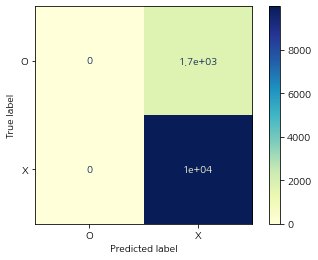

In [155]:
metrics_classification(model_lgbm, X_valid, Y_valid, val_preds)

# LogisticRegression

In [172]:
x_train = data.drop(columns=['일시', '폭염여부(O/X)', 'date'])
y_train = data['폭염여부(O/X)']

for i in x_train.select_dtypes('object').columns:
  if x_train[i].nunique() < 3:
    x_train[i] = LabelEncoder().fit_transform(x_train[i])
  else:
    x_train = pd.get_dummies(x_train, columns=[i])

x_train_columns = x_train.columns

x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x_train_columns)

from sklearn.metrics import make_scorer
score = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

cv_score = cross_val_score(LogisticRegression(), x_train, y_train, scoring=score, cv=10, n_jobs=-1, verbose=100)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   16.7s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished


Text(0.5, 1.0, 'Logistic model score')

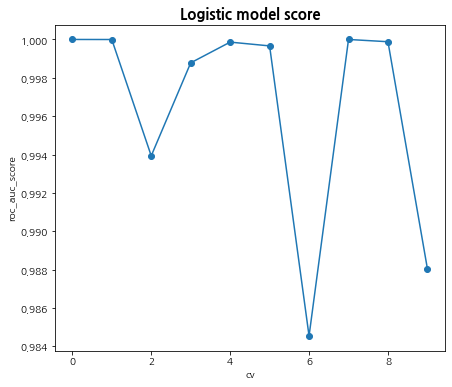

In [180]:
plt.figure(figsize=(7,6))
pd.Series(cv_score).plot(marker='o')
plt.ylabel('roc_auc_score')
plt.xlabel('cv')
plt.title('Logistic model score', fontsize=15, fontweight='bold')

# To_do

# 1. 시계열 별로 최저, 평균 온도 비교 시각화 계속 하기(완료)

# 2. 지역별로 온도 비교하기(완료)

# 3. 기온과 습도를 가지고 상관관계 나타내기(scatter, heatmap, correlation)(완료)

# 4. 폭염여부 classification 하기(완료)



# 프로젝트를 진행하면서 아쉬웠던 점

1. 비교적 적은 표본 --> 2019-2021년 데이터만 존재했다.
2. 적은 변수 --> 풍속, 일조량, 기압 등 다른 측정 변수가 더 있었으면...